## Pd2 Jamroży Bartosz

In [35]:
library(tidyverse)
library(reshape2)


library(DALEX)
library(DALEXtra)

library(lime)

options(warn=-1)

Dane
z: https://www.kaggle.com/camnugent/california-housing-prices

In [1]:
house <- read.csv(file = 'housing.csv', stringsAsFactors = FALSE)

# Model

przykładowy model z : https://www.kaggle.com/camnugent/introduction-to-machine-learning-in-r-tutorial

In [5]:
library(tidyverse)
library(reshape2)

housing = read.csv("housing.csv")

# par(mfrow=c(2,5))

# clean data
housing$total_bedrooms[is.na(housing$total_bedrooms)] = median(housing$total_bedrooms , na.rm = TRUE)

#Fix the total columns - make them means
housing$mean_bedrooms = housing$total_bedrooms/housing$households
housing$mean_rooms = housing$total_rooms/housing$households

drops = c('total_bedrooms', 'total_rooms')
housing = housing[ , !(names(housing) %in% drops)]

#Turn categoricals into booleans
categories = unique(housing$ocean_proximity)

#split the categories off
cat_housing = data.frame(ocean_proximity = housing$ocean_proximity)

for(cat in categories){
  cat_housing[,cat] = rep(0, times= nrow(cat_housing))
}


for(i in 1:length(cat_housing$ocean_proximity)){
  cat = as.character(cat_housing$ocean_proximity[i])
  cat_housing[,cat][i] = 1
}

cat_columns = names(cat_housing)
keep_columns = cat_columns[cat_columns != 'ocean_proximity']
cat_housing = select(cat_housing,one_of(keep_columns))

#Scale the numerical variables

drops = c('ocean_proximity','median_house_value')
housing_num =  housing[ , !(names(housing) %in% drops)]

scaled_housing_num = scale(housing_num)

#Merge the altered numerical and categorical dataframes
cleaned_housing = cbind(cat_housing, scaled_housing_num, median_house_value=housing$median_house_value)


# Create a test set of data

set.seed(1738) # Set a random seed so that same sample can be reproduced in future runs

sample = sample.int(n = nrow(cleaned_housing), size = floor(.8*nrow(cleaned_housing)), replace = F)
train = cleaned_housing[sample, ] #just the samples
test  = cleaned_housing[-sample, ] #everything but the samples

#Random forest model
library('randomForest')

set.seed(1738)

train_y = train[,'median_house_value']
train_x = train[, names(train) !='median_house_value']

rf_model = randomForest(train_x, y = train_y , ntree = 500, importance = TRUE)

#names(rf_model)
#rf_model$importance

Model pracuje na danych przeskalowanych, weźmy ramke nieskalowaną dla lepszego zrozumienia zmiennych.

In [41]:
x = cbind(cat_housing, housing_num, median_house_value=housing$median_house_value)
train_not_scaled=x[sample,]

### Tworzenie explainera
W tym zadaniu używam zbioru treningowego.

In [27]:
fr_model_expain <- explain(model = rf_model, data=train_x, y=train_y)

Preparation of a new explainer is initiated
  -> model label       :  randomForest  (  default  )
  -> data              :  16512  rows  13  cols 
  -> target variable   :  16512  values 
  -> predict function  :  yhat.randomForest  will be used (  default  )
  -> predicted values  :  No value for predict function target column. (  default  )
  -> model_info        :  package randomForest , ver. 4.6.14 , task regression (  default  ) 
  -> predicted values  :  numerical, min =  39702.65 , mean =  206688.3 , max =  499518.2  
  -> residual function :  difference between y and yhat (  default  )
  -> residuals         :  numerical, min =  -126586.5 , mean =  -173.9163 , max =  195986.5  
  A new explainer has been created!  


## "Dla wybranej obserwacji ze zbioru danych wylicz predykcję modelu."

In [25]:
predict(rf_model,train_x[100,])

14117 
110367.5

In [28]:
train_y[100]

[1] 102900

Dla obserwacji numer 100 ze zbioru treningowego model wyznaczył cenę nieruchomości na ok 110367 wobec rzeczywistej wartości 102900, myląc się o mniej niż 8%.

## "Dla wybranej obserwacji z punktu 1., wylicz dekompozycję predykcji modelu używając LIME (pakiety w R: live, lime, localModel, iml, pakiety w Python: lime, dalex)"

In [39]:
lime_100 <- predict_surrogate(explainer = fr_model_expain, 
                                     new_observation = train_x[100,], 
                                     n_features = 4, 
                                     n_permutations = 1000,
                                     type = "lime")

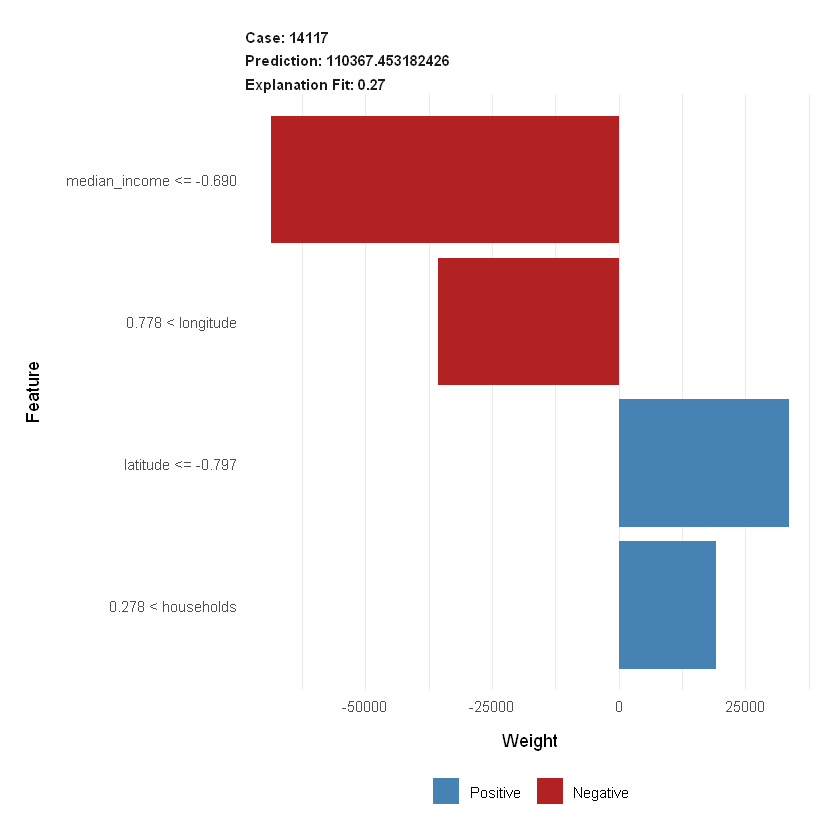

In [40]:
plot(lime_100)

Obserwacje:

W przypadku tej obserwacji na wyjaśniający model liniowy (uwzględniając 4 zmienne) największy wpływ na przewidywanie ceny nieruchomości miała mediana dochodów.

Median income <br>
Przy bardzo niskiej medianie dochodów obniża predykcje o ponad 60 tyś

Longnitude <br>
Wysoka szerokość geograficzna spowodowała obniżenie o ok 36 tyś

Latitude <br>
Niewielka długość geograficzna spowodowała podwyższenie przewidywania o ok 30 tyś 



## "Porównaj dekompozycję LIME dla różnych obserwacji w zbiorze. Jak stabilne są otrzymane wyjaśnienia?"

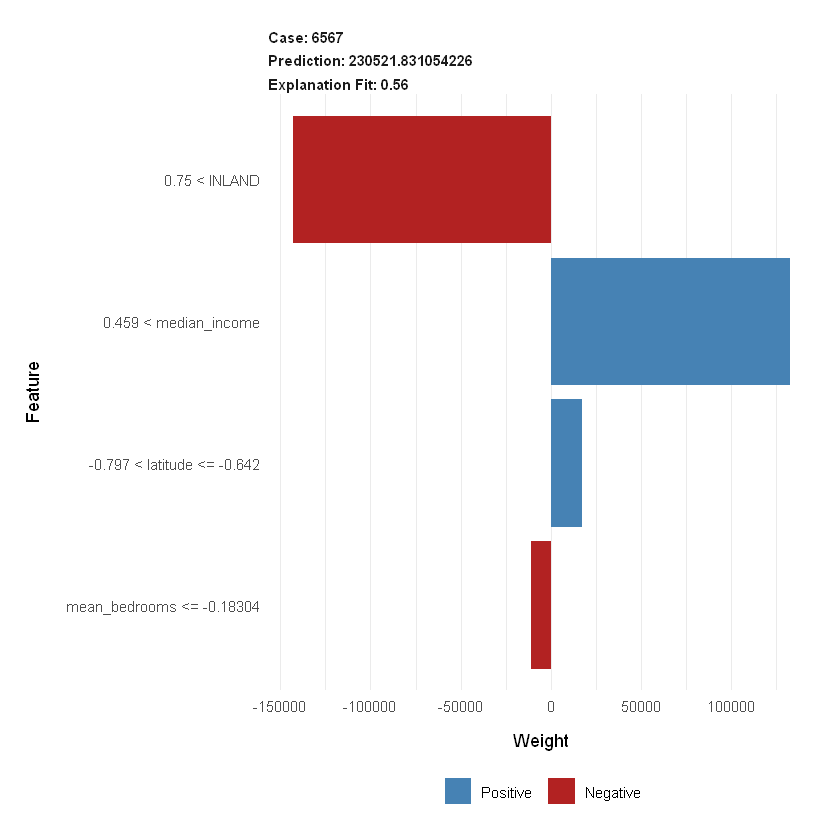

In [50]:
lime <- predict_surrogate(explainer = fr_model_expain, 
                                     new_observation = train_x[10,], 
                                     n_features = 4, 
                                     n_permutations = 1000,
                                     type = "lime")
plot(lime)

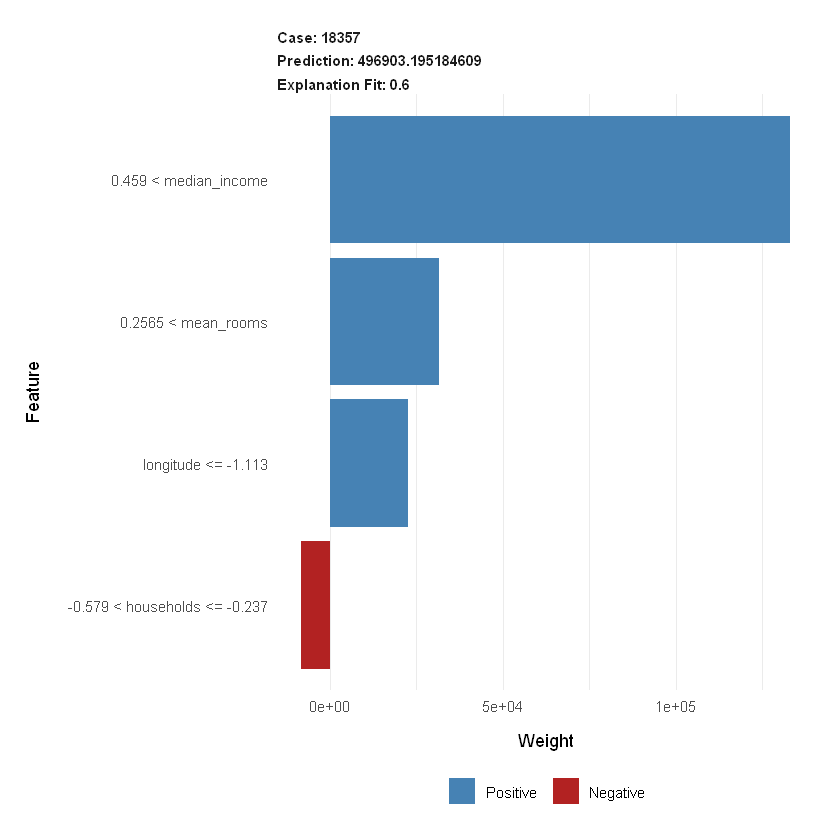

In [51]:
lime <- predict_surrogate(explainer = fr_model_expain, 
                                     new_observation = train_x[67,], 
                                     n_features = 4, 
                                     n_permutations = 1000,
                                     type = "lime")
plot(lime)

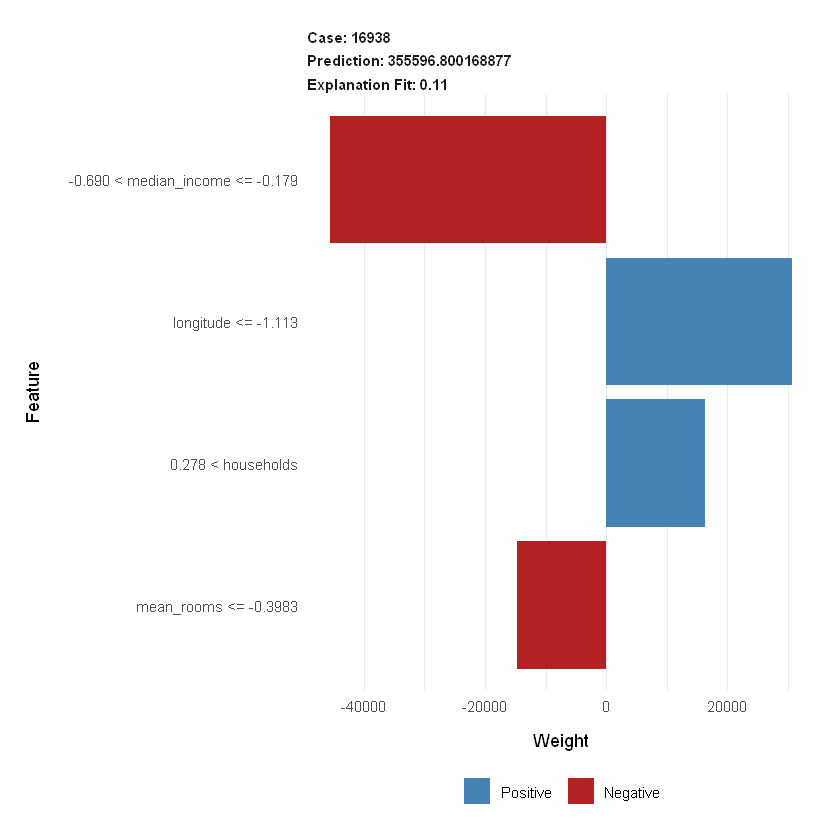

In [52]:
lime <- predict_surrogate(explainer = fr_model_expain, 
                                     new_observation = train_x[167,], 
                                     n_features = 4, 
                                     n_permutations = 1000,
                                     type = "lime")
plot(lime)

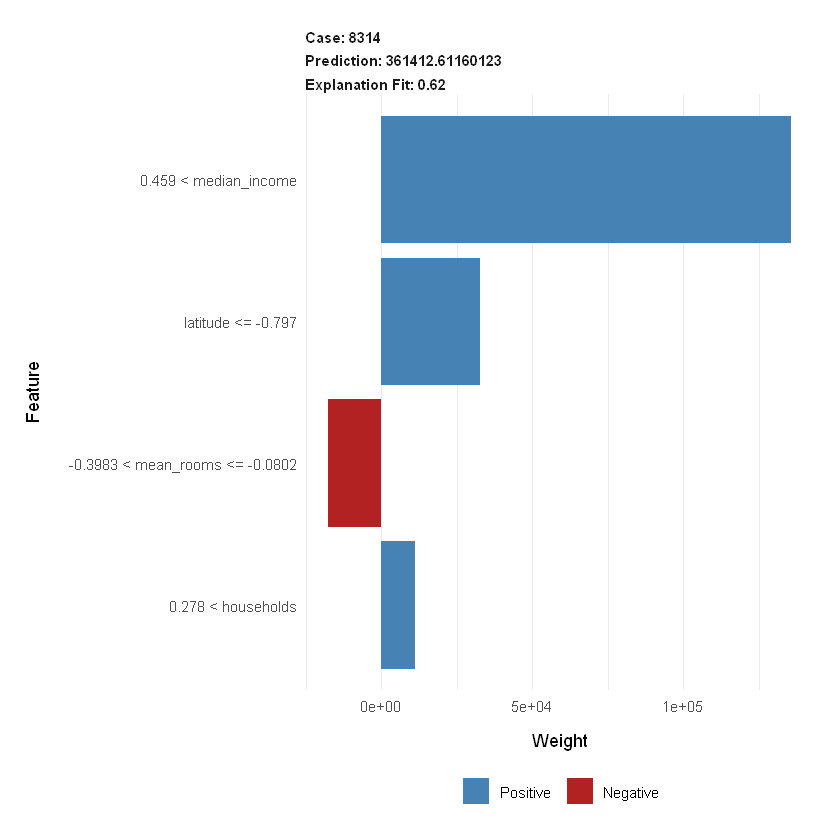

In [63]:
lime <- predict_surrogate(explainer = fr_model_expain, 
                                     new_observation = train_x[287,], 
                                     n_features = 4, 
                                     n_permutations = 1000,
                                     type = "lime")
plot(lime)

W każdym powyższym przypadku model uwzględniał jako istotną medianę dochodów. <br>
W trzech na pięć przypadków próg na ten zmiennej był na tym samym poziomie 0.459, wartości poniżej miały negatywny wpływ zaś większe pozytywny.  <br>
Podobnie w przypadku longitude gdzie powtarza się próg -1.113 poniżej którego model reaguje pozytywnie <br>
Wydaje się że w przypadku tego modelu Lime działa całkiem „normlanie”, „stabilnie”


## "Dla wybranej obserwacji porównaj wyjaśnienie LIME wyjaśnieniem BreakDown lub SHAP"

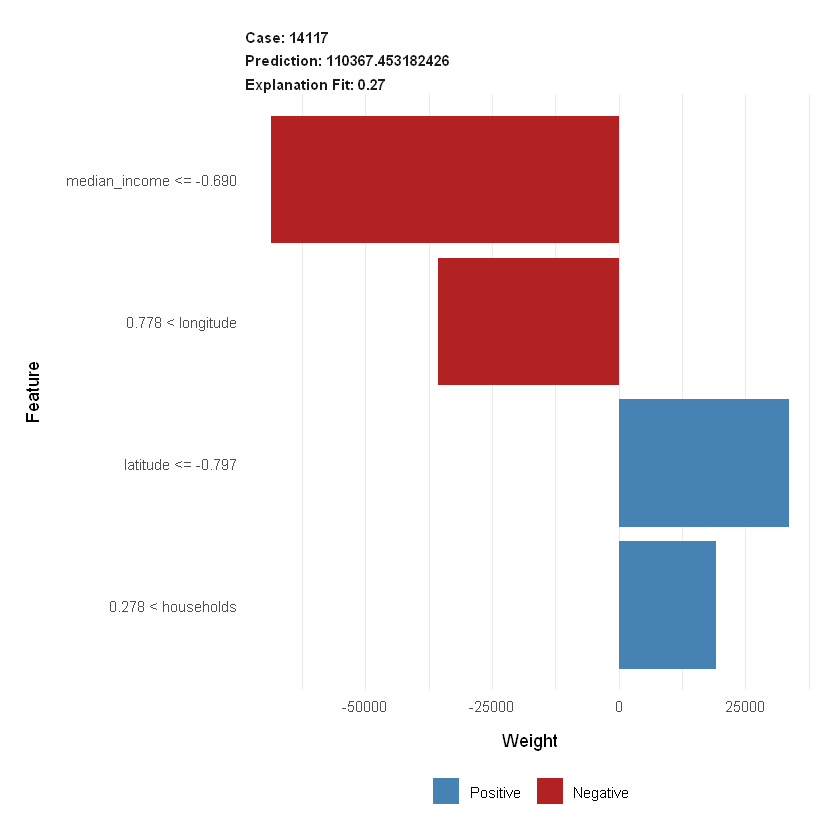

In [64]:
plot(lime_100)

In [71]:
predict_100 <- predict_parts(fr_model_expain, new_observation = train_x[100,])


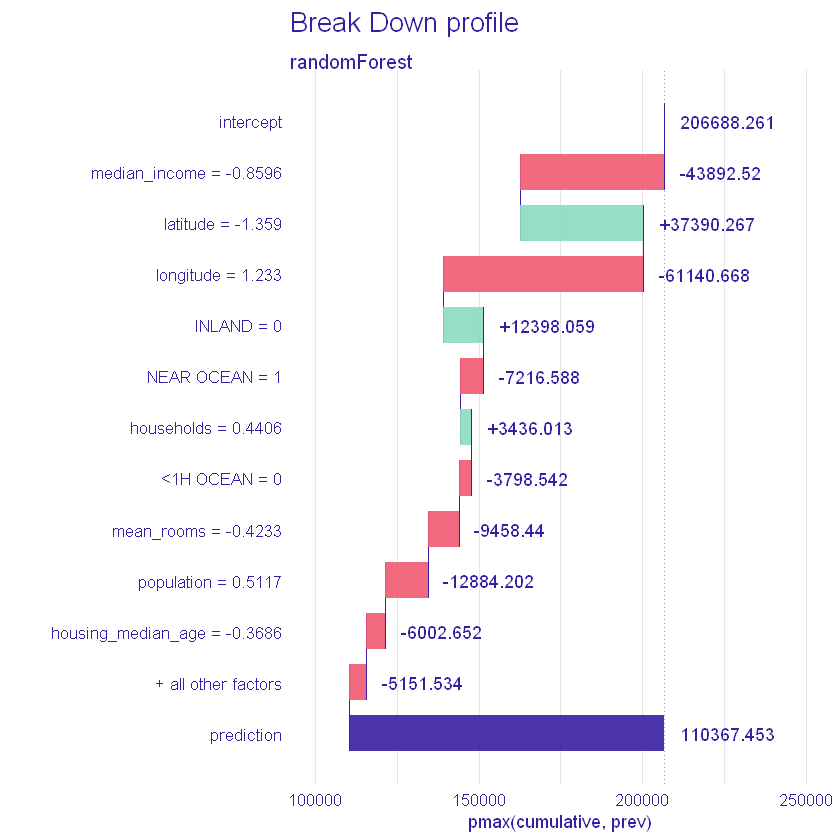

In [72]:
suppressMessages(plot(predict_100) + ylim(100000,250000))

Brak Down i LIME wskazały takie sam wpływ zmiennych (pozytywny/negatywny)<br>
W przypadku median_income oraz latitude różnice w wartościach liczbowych były niewielkie,zaś w dwóch pozostałych już znaczne : <br>
longitude –30 000 vs -60 000<br>
households 20 000 vs 34 000<br>
dla wyjaśnienia Brak Down spore znaczenie miały też pozostałe zmienne w sumie obniżając predykcje o ok 50 tyś.

